# Quantium Virtual Internship
###### Milesh Bhadresa

## Task 2: Retail Strategy and Analytics

### Importing the required libraries

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind
from scipy.spatial import distance
from scipy.stats import t


In [2]:
data=pd.read_csv('Task2_data.csv')
#data=pd.read_csv('Data.csv')
data["DATE"]=pd.to_datetime(data["DATE"],format="%Y-%m")
data["Dummy"]=1


The dummy column introduced above will assist us in calculating the monthly number of customers.

#### Adding the Month Id Column

In [3]:
data['MonthId']=data["DATE"].dt.strftime("%Y%m")


#### Creating a new table of monthly data

For each store and month, the following have been considered:
* Total sales
* Number of customers
* Transactions per customer
* Chips per customer
* Average price per unit

In [4]:
Monthly_data=data.groupby(['STORE_NBR','MonthId']).sum()
Monthly_data.reset_index(inplace=True)
Monthly_data=Monthly_data[['STORE_NBR','MonthId','TOT_SALES','Dummy','PROD_QTY']]
Monthly_data=Monthly_data.rename(columns={'TOT_SALES':'Monthly Overall Sales','Dummy':'Monthly Number of Customers','PROD_QTY':'Monthly Product Quantity'})
Monthly_data['Chips per Customer']=Monthly_data['Monthly Product Quantity']/Monthly_data['Monthly Number of Customers']
Monthly_data['Average Price per Unit']=Monthly_data['Monthly Overall Sales']/Monthly_data['Monthly Product Quantity']
Monthly_data['Transaction per Customer']=(Monthly_data['Chips per Customer']*Monthly_data['Average Price per Unit'])
Monthly_data.head()


,STORE_NBR,MonthId,Monthly Overall Sales,Monthly Number of Customers,Monthly Product Quantity,Chips per Customer,Average Price per Unit,Transaction per Customer
0,1,201807,206.9,52,62,1.192308,3.337097,3.978846
1,1,201808,176.1,43,54,1.255814,3.261111,4.095349
2,1,201809,278.8,62,75,1.209677,3.717333,4.496774
3,1,201810,188.1,45,58,1.288889,3.243103,4.180000
4,1,201811,192.6,47,57,1.212766,3.378947,4.097872


#### Filter to the pre-trial period

In [5]:
Pre_trial=Monthly_data[(Monthly_data['MonthId']<'201902')]


#### Split Trial stores and Control stores

In [6]:
Storenumbers=Pre_trial['STORE_NBR'].unique()

Measure=np.array(['Monthly Overall Sales','Monthly Number of Customers','Transaction per Customer','Chips per Customer','Average Price per Unit']
)
Trial_Storenumbers=np.array([77,86,88])
Control_Storenumbers=np.delete(Storenumbers,[10,30,43,75,76,84,85,87,115,191,204,209,216,250],axis=0)


### Calculating the Correlation and Standardized distance (Euclidean distance)

In [7]:
def Corr_Table(trial, measure, store):
    #initial table generation
    #store1=Pre_trial[Pre_trial['STORE_NBR']==trial]
    #store2=Pre_trial[Pre_trial['STORE_NBR']==store]
    measure1=Pre_trial[measure][Pre_trial['STORE_NBR']==trial]
    measure2=Pre_trial[measure][Pre_trial['STORE_NBR']==store]
    
    #Correlation calculation
    correlation=np.corrcoef(measure1,measure2)[0,1]
    return (trial,store,measure,correlation)

#### Calculating the Distance using Euclidean distance. 
def Dist_Table(trial, measure, store):
    #initial table generation
    #store1=Pre_trial[Pre_trial['STORE_NBR']==trial]
    #store2=Pre_trial[Pre_trial['STORE_NBR']==store]
    measure1=Pre_trial[measure][Pre_trial['STORE_NBR']==trial]
    measure2=Pre_trial[measure][Pre_trial['STORE_NBR']==store]
    
    #Distance calculation
    Distance=distance.euclidean(measure1,measure2)
    return (trial,store,measure,Distance)


#### Generating Table of combined correlation and distance

In [8]:
Table=np.array([0,0,0,0,0,0,0,0])
Error=[]
for i in Trial_Storenumbers:
    for j in Control_Storenumbers:       
        for k in range(len(Measure)):
            temp=Measure[k]
            try:
                #Correlation
                bins=Corr_Table(i, temp, j)
                bins=np.array(bins)
                Table=np.append(Table,bins,axis=0)
                #Distance            
                bins=Dist_Table(i, temp, j)
                bins=np.array(bins)
                Table=np.append(Table,bins,axis=0)
            
            except:
                Error.append([i,j])

Table=Table.reshape(-1,8)
Table=pd.DataFrame(Table)
Table=Table.rename(columns={0:'TrialStore',1:'ControlStore',2:'Measure',3:'Correlation',4:'TrialStore_d',5:'ControlStore_d',6:'Measure_d',7:'Distance'})
Table=Table.drop(0)
Table['TrialStore']=Table['TrialStore'].astype(int)
Table['ControlStore']=Table['ControlStore'].astype(int)
Table['Correlation']=Table['Correlation'].astype(float)
Table['TrialStore_d']=Table['TrialStore_d'].astype(int)
Table['ControlStore_d']=Table['ControlStore_d'].astype(int)
Table['Distance']=Table['Distance'].astype(float)
min=Table['Distance'].min()
max=Table['Distance'].max()
Table['Distance']=1-(Table['Distance']-min)/(max-min)
Table.head()


/home/altec/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/altec/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,TrialStore,ControlStore,Measure,Correlation,TrialStore_d,ControlStore_d,Measure_d,Distance
1,77,1,Monthly Overall Sales,0.075218,77,1,Monthly Overall Sales,0.951617
2,77,1,Monthly Number of Customers,0.355839,77,1,Monthly Number of Customers,0.994095
3,77,1,Transaction per Customer,-0.805592,77,1,Transaction per Customer,0.999079
4,77,1,Chips per Customer,-0.796089,77,1,Chips per Customer,0.999752
5,77,1,Average Price per Unit,-0.842303,77,1,Average Price per Unit,0.999672


### Correlations and Magnitudes with Store 77

In [9]:
Tstore=77
Store=Table[(Table['Measure']=='Monthly Overall Sales') | (Table['Measure']=='Monthly Number of Customers')]
Store=Store[Store['TrialStore']==Tstore]
Store['Combined Score']=0.5*Store['Correlation']+0.5*Store['Distance']
Store.sort_values('Combined Score',ascending=False)


,TrialStore,ControlStore,Measure,Correlation,TrialStore_d,ControlStore_d,Measure_d,Distance,Combined Score
1092,77,233,Monthly Number of Customers,0.964640,77,233,Monthly Number of Customers,0.998290,0.981465
1091,77,233,Monthly Overall Sales,0.903774,77,233,Monthly Overall Sales,0.983519,0.943647
1192,77,254,Monthly Number of Customers,0.883996,77,254,Monthly Number of Customers,0.995062,0.939529
192,77,41,Monthly Number of Customers,0.874697,77,41,Monthly Number of Customers,0.997944,0.936321
542,77,119,Monthly Number of Customers,0.910435,77,119,Monthly Number of Customers,0.948325,0.929380
...,...,...,...,...,...,...,...,...,...
1161,77,247,Monthly Overall Sales,-0.631050,77,247,Monthly Overall Sales,0.533217,-0.048916
946,77,201,Monthly Overall Sales,-0.410908,77,201,Monthly Overall Sales,0.297878,-0.056515
111,77,24,Monthly Overall Sales,-0.718112,77,24,Monthly Overall Sales,0.597620,-0.060246
256,77,55,Monthly Overall Sales,-0.666782,77,55,Monthly Overall Sales,0.478706,-0.094038


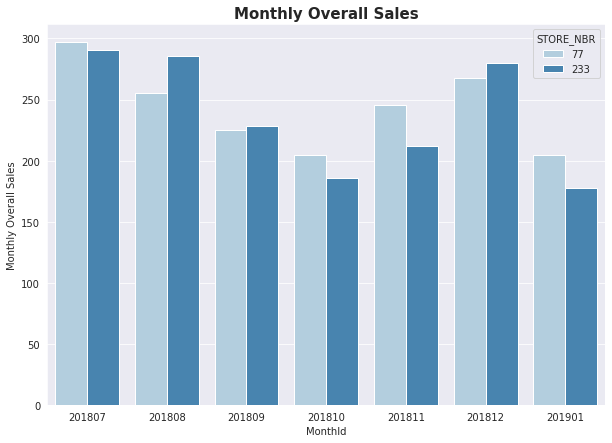

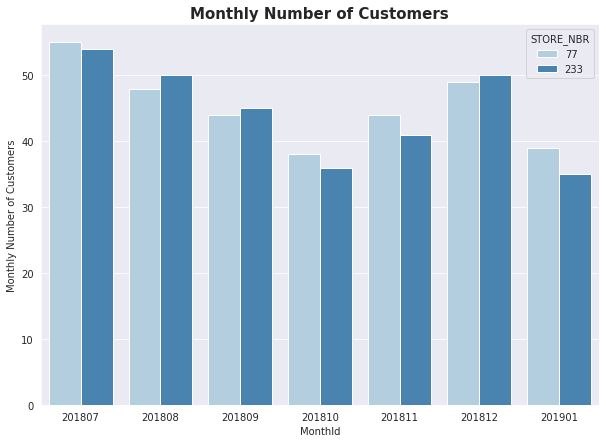

In [10]:
# Viz after picking a control for Pre-trial
Cnt_store=233
plot=Pre_trial[(Pre_trial['STORE_NBR']==Cnt_store) | (Pre_trial['STORE_NBR']==Tstore)]

#Monthly Overall Sales
fig,ax=plt.subplots(figsize=(10,7))
fig=sns.barplot('MonthId','Monthly Overall Sales',palette="Blues",hue='STORE_NBR' ,data=plot).set_title("Monthly Overall Sales",fontsize=15,fontweight="bold")

plt.show()
#fig,ax=plt.subplots(figsize=(10,7))
fig,ax=plt.subplots(figsize=(10,7))
fig=sns.barplot('MonthId','Monthly Number of Customers',palette="Blues",hue='STORE_NBR' ,data=plot).set_title("Monthly Number of Customers",fontsize=15,fontweight="bold")
plt.show()


Based on the information above, the ideal control store for the pre-trial is 233.

#### Scaling pre-trial control sales to match pre-trial trial store sales

In [11]:
scale=(Pre_trial[Pre_trial['STORE_NBR']==Tstore]['Monthly Overall Sales'].sum())/(Pre_trial[Pre_trial['STORE_NBR']==Cnt_store]['Monthly Overall Sales'].sum())


Trial=Monthly_data[Monthly_data['STORE_NBR']==Tstore][['STORE_NBR','MonthId','Monthly Overall Sales']]
Scaled_control=Monthly_data[Monthly_data['STORE_NBR']==Cnt_store]
a=Scaled_control[Scaled_control['MonthId'] < '201902']['Monthly Overall Sales']*scale
Scaled_control.loc[a.index,'Monthly Overall Sales']=a

Scaled_control=Scaled_control[['STORE_NBR','MonthId','Monthly Overall Sales']]

Combined_Scaledcontrol_trial=pd.merge(Scaled_control,Trial,how='right',on='MonthId')


Combined_Scaledcontrol_trial['Change%']=(Combined_Scaledcontrol_trial['Monthly Overall Sales_x']-Combined_Scaledcontrol_trial['Monthly Overall Sales_y'])/Combined_Scaledcontrol_trial['Monthly Overall Sales_x']
Combined_Scaledcontrol_trial


/home/altec/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,STORE_NBR_x,MonthId,Monthly Overall Sales_x,STORE_NBR_y,Monthly Overall Sales_y,Change%
0,233,201807,297.565550,77,296.8,0.002573
1,233,201808,292.652187,77,255.5,0.126950
2,233,201809,233.998916,77,225.2,0.037602
3,233,201810,190.085733,77,204.5,-0.075830
4,233,201811,216.597421,77,245.3,-0.132516
5,233,201812,286.408121,77,267.3,0.066716
6,233,201901,181.692071,77,204.4,-0.124980
7,233,201902,244.000000,77,235.0,0.036885
8,233,201903,199.100000,77,278.5,-0.398795
9,233,201904,158.600000,77,263.5,-0.661412


#### Null hypothesis: Trial period is the same as the Pre-trial


In [12]:
Combined_Scaledcontrol_trial=Combined_Scaledcontrol_trial[Combined_Scaledcontrol_trial['MonthId']<'201905']
df=Combined_Scaledcontrol_trial['MonthId'].nunique()-1
std=Combined_Scaledcontrol_trial[Combined_Scaledcontrol_trial['MonthId']<'201902']['Change%'].std()
mean=0#Combined_Scaledcontrol_trial['Change%'].mean()
tvalue=t.ppf(0.95,df)
Combined_Scaledcontrol_trial['t-value']=(Combined_Scaledcontrol_trial['Change%']-mean)/std
print("The T-value is:" ,tvalue)
Combined_Scaledcontrol_trial


The T-value is: 1.8331129326536335


/home/altec/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR_x,MonthId,Monthly Overall Sales_x,STORE_NBR_y,Monthly Overall Sales_y,Change%,t-value
0,233,201807,297.565550,77,296.8,0.002573,0.025834
1,233,201808,292.652187,77,255.5,0.126950,1.274771
2,233,201809,233.998916,77,225.2,0.037602,0.377585
3,233,201810,190.085733,77,204.5,-0.075830,-0.761452
4,233,201811,216.597421,77,245.3,-0.132516,-1.330661
5,233,201812,286.408121,77,267.3,0.066716,0.669934
6,233,201901,181.692071,77,204.4,-0.124980,-1.254993
7,233,201902,244.000000,77,235.0,0.036885,0.370384
8,233,201903,199.100000,77,278.5,-0.398795,-4.004506
9,233,201904,158.600000,77,263.5,-0.661412,-6.641589


As the T-value is 1.833 and this is a 2 sided test, March 2019 and April 2019 are statistically different as the |t-value|>1.833. We therefore reject the Null hypothesis and conclude that the Trial period is different from the Pre-trial period.

### Visual version

In [13]:
TrialAssessment=Combined_Scaledcontrol_trial[['STORE_NBR_x','MonthId','Monthly Overall Sales_x','STORE_NBR_y','Monthly Overall Sales_y']]
TrialAssessment['Control 95th% confidence interval']=TrialAssessment['Monthly Overall Sales_x']*(1 + std * 2)
TrialAssessment['Control 5th% confidence interval']=TrialAssessment['Monthly Overall Sales_x']*(1 - std * 2)

TrialAssessment


/home/altec/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR_x,MonthId,Monthly Overall Sales_x,STORE_NBR_y,Monthly Overall Sales_y,Control 95th% confidence interval,Control 5th% confidence interval
0,233,201807,297.565550,77,296.8,356.832555,238.298545
1,233,201808,292.652187,77,255.5,350.940583,234.363791
2,233,201809,233.998916,77,225.2,280.605167,187.392664
3,233,201810,190.085733,77,204.5,227.945667,152.225799
4,233,201811,216.597421,77,245.3,259.737766,173.457077
5,233,201812,286.408121,77,267.3,343.452868,229.363375
6,233,201901,181.692071,77,204.4,217.880215,145.503928
7,233,201902,244.000000,77,235.0,292.598197,195.401803
8,233,201903,199.100000,77,278.5,238.755332,159.444668
9,233,201904,158.600000,77,263.5,190.188828,127.011172


#### Plot

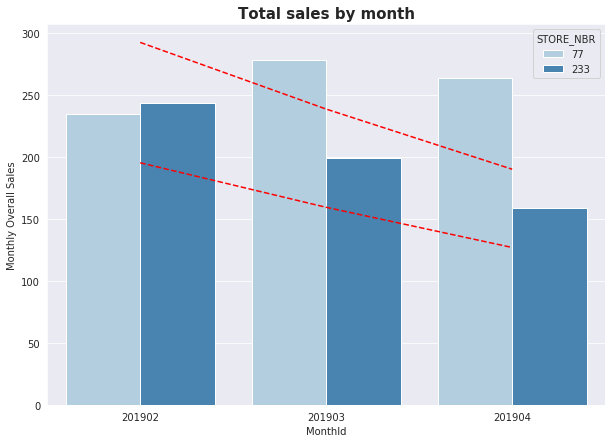

In [14]:
plot=TrialAssessment[(TrialAssessment['MonthId']>'201901') & (TrialAssessment['MonthId']<'201905')]
a=plot[['STORE_NBR_x','MonthId','Monthly Overall Sales_x']]
b=plot[['STORE_NBR_y','MonthId','Monthly Overall Sales_y']]
b=b.rename(columns={'STORE_NBR_y':'STORE_NBR_x','Monthly Overall Sales_y':'Monthly Overall Sales_x'})
a=a.append(b)
a=a.rename(columns={'STORE_NBR_x':'STORE_NBR','Monthly Overall Sales_x':'Monthly Overall Sales'})



fig,ax=plt.subplots(figsize=(10,7))
fig=sns.lineplot('MonthId','Control 95th% confidence interval',data=plot,color='red').set_title("Total sales by month",fontsize=15,fontweight="bold")
fig=sns.lineplot('MonthId','Control 5th% confidence interval',data=plot,color='red')
fig=sns.barplot('MonthId','Monthly Overall Sales',palette="Blues",hue='STORE_NBR' ,data=a)
fig.lines[0].set_linestyle("--")
fig.lines[1].set_linestyle("--")

plt.show()


### Number of customers Store 77

#### Apply scaling

In [15]:
scale=(Pre_trial[Pre_trial['STORE_NBR']==Tstore]['Monthly Number of Customers'].sum())/(Pre_trial[Pre_trial['STORE_NBR']==Cnt_store]['Monthly Number of Customers'].sum())


Trial=Monthly_data[Monthly_data['STORE_NBR']==Tstore][['STORE_NBR','MonthId','Monthly Number of Customers']]
Scaled_control=Monthly_data[Monthly_data['STORE_NBR']==Cnt_store]
a=Scaled_control[Scaled_control['MonthId'] < '201902']['Monthly Number of Customers']*scale
Scaled_control.loc[a.index,'Monthly Number of Customers']=a

Scaled_control=Scaled_control[['STORE_NBR','MonthId','Monthly Number of Customers']]

Combined_Scaledcontrol_trial=pd.merge(Scaled_control,Trial,how='right',on='MonthId')


Combined_Scaledcontrol_trial['Change%']=(Combined_Scaledcontrol_trial['Monthly Number of Customers_x']-Combined_Scaledcontrol_trial['Monthly Number of Customers_y'])/Combined_Scaledcontrol_trial['Monthly Number of Customers_x']
Combined_Scaledcontrol_trial


/home/altec/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,STORE_NBR_x,MonthId,Monthly Number of Customers_x,STORE_NBR_y,Monthly Number of Customers_y,Change%
0,233,201807,55.041801,77,55,0.000759
1,233,201808,50.964630,77,48,0.058170
2,233,201809,45.868167,77,44,0.040729
3,233,201810,36.694534,77,38,-0.035577
4,233,201811,41.790997,77,44,-0.052858
5,233,201812,50.964630,77,49,0.038549
6,233,201901,35.675241,77,39,-0.093195
7,233,201902,47.000000,77,45,0.042553
8,233,201903,41.000000,77,55,-0.341463
9,233,201904,33.000000,77,48,-0.454545


#### Null hypothesis: Trial period is the same as the Pre-trial

In [16]:
Combined_Scaledcontrol_trial=Combined_Scaledcontrol_trial[Combined_Scaledcontrol_trial['MonthId']<'201905']
df=Combined_Scaledcontrol_trial['MonthId'].nunique()-1
std=Combined_Scaledcontrol_trial[Combined_Scaledcontrol_trial['MonthId']<'201902']['Change%'].std()
mean=0#Combined_Scaledcontrol_trial['Change%'].mean()
tvalue=t.ppf(0.95,df)
Combined_Scaledcontrol_trial['t-value']=(Combined_Scaledcontrol_trial['Change%']-mean)/std
print("The T-value is:" ,tvalue)
Combined_Scaledcontrol_trial


The T-value is: 1.8331129326536335


/home/altec/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR_x,MonthId,Monthly Number of Customers_x,STORE_NBR_y,Monthly Number of Customers_y,Change%,t-value
0,233,201807,55.041801,77,55,0.000759,0.013494
1,233,201808,50.964630,77,48,0.058170,1.033581
2,233,201809,45.868167,77,44,0.040729,0.723681
3,233,201810,36.694534,77,38,-0.035577,-0.632131
4,233,201811,41.790997,77,44,-0.052858,-0.939196
5,233,201812,50.964630,77,49,0.038549,0.684943
6,233,201901,35.675241,77,39,-0.093195,-1.655907
7,233,201902,47.000000,77,45,0.042553,0.756092
8,233,201903,41.000000,77,55,-0.341463,-6.067180
9,233,201904,33.000000,77,48,-0.454545,-8.076440


As the T-value is 1.833 and this is a 2 sided test, March 2019 and April 2019 are statistically different as the |t-value|>1.833. We therefore reject the Null hypothesis and conclude that the Trial period is different from the Pre-trial period.

### Visual version

In [17]:
TrialAssessment=Combined_Scaledcontrol_trial[['STORE_NBR_x','MonthId','Monthly Number of Customers_x','STORE_NBR_y','Monthly Number of Customers_y']]


In [18]:
TrialAssessment['Control 95th% confidence interval']=TrialAssessment['Monthly Number of Customers_x']*(1 + std * 2)
TrialAssessment['Control 5th% confidence interval']=TrialAssessment['Monthly Number of Customers_x']*(1 - std * 2)

TrialAssessment


/home/altec/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STORE_NBR_x,MonthId,Monthly Number of Customers_x,STORE_NBR_y,Monthly Number of Customers_y,Control 95th% confidence interval,Control 5th% confidence interval
0,233,201807,55.041801,77,55,61.237352,48.846249
1,233,201808,50.964630,77,48,56.701252,45.228009
2,233,201809,45.868167,77,44,51.031127,40.705208
3,233,201810,36.694534,77,38,40.824901,32.564166
4,233,201811,41.790997,77,44,46.495026,37.086967
5,233,201812,50.964630,77,49,56.701252,45.228009
6,233,201901,35.675241,77,39,39.690876,31.659606
7,233,201902,47.000000,77,45,52.290359,41.709641
8,233,201903,41.000000,77,55,45.614994,36.385006
9,233,201904,33.000000,77,48,36.714508,29.285492


#### Plot

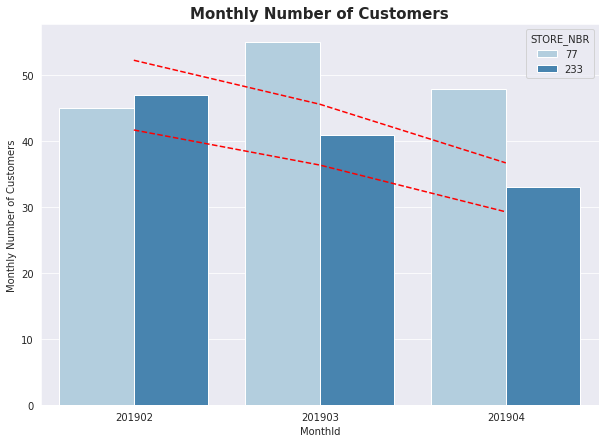

In [19]:
plot=TrialAssessment[(TrialAssessment['MonthId']>'201901') & (TrialAssessment['MonthId']<'201905')]
a=plot[['STORE_NBR_x','MonthId','Monthly Number of Customers_x']]
b=plot[['STORE_NBR_y','MonthId','Monthly Number of Customers_y']]
b=b.rename(columns={'STORE_NBR_y':'STORE_NBR_x','Monthly Number of Customers_y':'Monthly Number of Customers_x'})
a=a.append(b)
a=a.rename(columns={'STORE_NBR_x':'STORE_NBR','Monthly Number of Customers_x':'Monthly Number of Customers'})



fig,ax=plt.subplots(figsize=(10,7))
fig=sns.lineplot('MonthId','Control 95th% confidence interval',data=plot,color='red').set_title("Monthly Number of Customers",fontsize=15,fontweight="bold")
fig=sns.lineplot('MonthId','Control 5th% confidence interval',data=plot,color='red')
fig=sns.barplot('MonthId','Monthly Number of Customers',palette="Blues",hue='STORE_NBR' ,data=a)
fig.lines[0].set_linestyle("--")
fig.lines[1].set_linestyle("--")
plt.show()


### Correlations and Magnitudes with Store 86

In [20]:
Tstore=86
Store=Table[(Table['Measure']=='Monthly Overall Sales') | (Table['Measure']=='Monthly Number of Customers')]
Store=Store[Store['TrialStore']==Tstore]
Store['Combined Score']=0.5*Store['Correlation']+0.5*Store['Distance']
Store.sort_values(['Combined Score','ControlStore_d'],ascending=False)


,TrialStore,ControlStore,Measure,Correlation,TrialStore_d,ControlStore_d,Measure_d,Distance,Combined Score
1922,86,138,Monthly Number of Customers,0.862971,86,138,Monthly Number of Customers,0.993468,0.928220
2006,86,155,Monthly Overall Sales,0.877882,86,155,Monthly Overall Sales,0.967321,0.922601
1967,86,147,Monthly Number of Customers,0.785668,86,147,Monthly Number of Customers,0.992588,0.889128
2321,86,222,Monthly Overall Sales,0.795075,86,222,Monthly Overall Sales,0.964231,0.879653
1781,86,109,Monthly Overall Sales,0.788300,86,109,Monthly Overall Sales,0.969902,0.879101
...,...,...,...,...,...,...,...,...,...
2286,86,214,Monthly Overall Sales,-0.789788,86,214,Monthly Overall Sales,0.499461,-0.145164
2476,86,254,Monthly Overall Sales,-0.793506,86,254,Monthly Overall Sales,0.444015,-0.174745
1481,86,42,Monthly Overall Sales,-0.745720,86,42,Monthly Overall Sales,0.356208,-0.194756
1961,86,146,Monthly Overall Sales,-0.775127,86,146,Monthly Overall Sales,0.355470,-0.209828


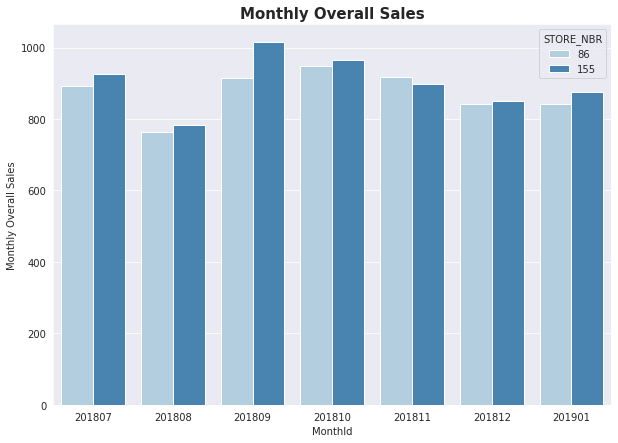

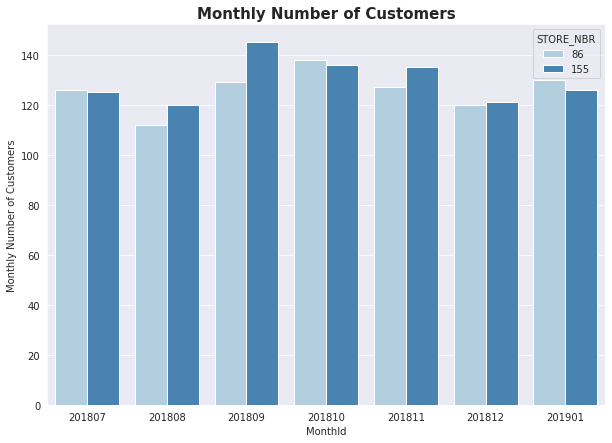

In [21]:
# Viz after picking a control for Pre-trial
Cnt_store=155
plot=Pre_trial[(Pre_trial['STORE_NBR']==Cnt_store) | (Pre_trial['STORE_NBR']==Tstore)]

#Monthly Overall Sales
fig,ax=plt.subplots(figsize=(10,7))
fig=sns.barplot('MonthId','Monthly Overall Sales',palette="Blues",hue='STORE_NBR' ,data=plot).set_title("Monthly Overall Sales",fontsize=15,fontweight="bold")
plt.show()
#fig,ax=plt.subplots(figsize=(10,7))
fig,ax=plt.subplots(figsize=(10,7))
fig=sns.barplot('MonthId','Monthly Number of Customers',palette="Blues",hue='STORE_NBR' ,data=plot).set_title("Monthly Number of Customers",fontsize=15,fontweight="bold")
plt.show()


Based on the information above, the ideal control store for the pre-trial is 155. 

#### Scaling pre-trial control sales to match pre-trial trial store sales

In [22]:
scale=(Pre_trial[Pre_trial['STORE_NBR']==Tstore]['Monthly Overall Sales'].sum())/(Pre_trial[Pre_trial['STORE_NBR']==Cnt_store]['Monthly Overall Sales'].sum())


Trial=Monthly_data[Monthly_data['STORE_NBR']==Tstore][['STORE_NBR','MonthId','Monthly Overall Sales']]
Scaled_control=Monthly_data[Monthly_data['STORE_NBR']==Cnt_store]
a=Scaled_control[Scaled_control['MonthId'] < '201902']['Monthly Overall Sales']*scale
Scaled_control.loc[a.index,'Monthly Overall Sales']=a

Scaled_control=Scaled_control[['STORE_NBR','MonthId','Monthly Overall Sales']]

Combined_Scaledcontrol_trial=pd.merge(Scaled_control,Trial,how='right',on='MonthId')


Combined_Scaledcontrol_trial['Change%']=(Combined_Scaledcontrol_trial['Monthly Overall Sales_x']-Combined_Scaledcontrol_trial['Monthly Overall Sales_y'])/Combined_Scaledcontrol_trial['Monthly Overall Sales_x']
Combined_Scaledcontrol_trial


/home/altec/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,STORE_NBR_x,MonthId,Monthly Overall Sales_x,STORE_NBR_y,Monthly Overall Sales_y,Change%
0,155,201807,896.922236,86,892.20,0.005265
1,155,201808,759.269991,86,764.05,-0.006296
2,155,201809,984.034086,86,914.60,0.070561
3,155,201810,934.948790,86,948.40,-0.014387
4,155,201811,871.894555,86,918.00,-0.052880
5,155,201812,824.361363,86,841.20,-0.020426
6,155,201901,848.418979,86,841.40,0.008273
7,155,201902,891.200000,86,913.20,-0.024686
8,155,201903,804.400000,86,1026.80,-0.276479
9,155,201904,844.600000,86,848.20,-0.004262


#### Null hypothesis: Trial period is the same as the Pre-trial

In [23]:
Combined_Scaledcontrol_trial=Combined_Scaledcontrol_trial[Combined_Scaledcontrol_trial['MonthId']<'201905']
df=Combined_Scaledcontrol_trial['MonthId'].nunique()-1
std=Combined_Scaledcontrol_trial[Combined_Scaledcontrol_trial['MonthId']<'201902']['Change%'].std()
mean=0#Combined_Scaledcontrol_trial['Change%'].mean()
tvalue=t.ppf(0.95,df)
Combined_Scaledcontrol_trial['t-value']=(Combined_Scaledcontrol_trial['Change%']-mean)/std
print("The T-value is:" ,tvalue)
Combined_Scaledcontrol_trial


The T-value is: 1.8331129326536335


/home/altec/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR_x,MonthId,Monthly Overall Sales_x,STORE_NBR_y,Monthly Overall Sales_y,Change%,t-value
0,155,201807,896.922236,86,892.20,0.005265,0.139708
1,155,201808,759.269991,86,764.05,-0.006296,-0.167055
2,155,201809,984.034086,86,914.60,0.070561,1.872364
3,155,201810,934.948790,86,948.40,-0.014387,-0.381770
4,155,201811,871.894555,86,918.00,-0.052880,-1.403188
5,155,201812,824.361363,86,841.20,-0.020426,-0.542022
6,155,201901,848.418979,86,841.40,0.008273,0.219529
7,155,201902,891.200000,86,913.20,-0.024686,-0.655051
8,155,201903,804.400000,86,1026.80,-0.276479,-7.336525
9,155,201904,844.600000,86,848.20,-0.004262,-0.113104


As the T-value is 1.833 and this is a 2 sided test, March 2019 is the only month that is statistically different as the |t-value|>1.833. We therefore do not reject the Null hypothesis and conclude that the Trial period is the same as the Pre-trial period.

### Visual version

In [24]:
TrialAssessment=Combined_Scaledcontrol_trial[['STORE_NBR_x','MonthId','Monthly Overall Sales_x','STORE_NBR_y','Monthly Overall Sales_y']]
TrialAssessment['Control 95th% confidence interval']=TrialAssessment['Monthly Overall Sales_x']*(1 + std * 2)
TrialAssessment['Control 5th% confidence interval']=TrialAssessment['Monthly Overall Sales_x']*(1 - std * 2)

TrialAssessment


/home/altec/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR_x,MonthId,Monthly Overall Sales_x,STORE_NBR_y,Monthly Overall Sales_y,Control 95th% confidence interval,Control 5th% confidence interval
0,155,201807,896.922236,86,892.20,964.523853,829.320619
1,155,201808,759.269991,86,764.05,816.496669,702.043314
2,155,201809,984.034086,86,914.60,1058.201381,909.866792
3,155,201810,934.948790,86,948.40,1005.416493,864.481086
4,155,201811,871.894555,86,918.00,937.609820,806.179291
5,155,201812,824.361363,86,841.20,886.494019,762.228706
6,155,201901,848.418979,86,841.40,912.364873,784.473084
7,155,201902,891.200000,86,913.20,958.370328,824.029672
8,155,201903,804.400000,86,1026.80,865.028156,743.771844
9,155,201904,844.600000,86,848.20,908.258056,780.941944


#### Plot

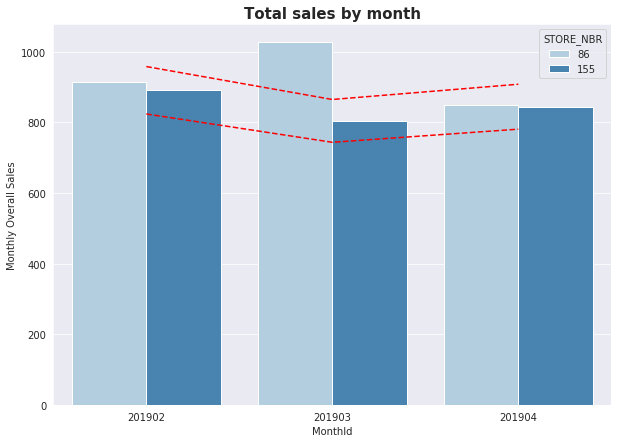

In [25]:
plot=TrialAssessment[(TrialAssessment['MonthId']>'201901') & (TrialAssessment['MonthId']<'201905')]
a=plot[['STORE_NBR_x','MonthId','Monthly Overall Sales_x']]
b=plot[['STORE_NBR_y','MonthId','Monthly Overall Sales_y']]
b=b.rename(columns={'STORE_NBR_y':'STORE_NBR_x','Monthly Overall Sales_y':'Monthly Overall Sales_x'})
a=a.append(b)
a=a.rename(columns={'STORE_NBR_x':'STORE_NBR','Monthly Overall Sales_x':'Monthly Overall Sales'})



fig,ax=plt.subplots(figsize=(10,7))
fig=sns.lineplot('MonthId','Control 95th% confidence interval',data=plot,color='red').set_title("Total sales by month",fontsize=15,fontweight="bold")
fig=sns.lineplot('MonthId','Control 5th% confidence interval',data=plot,color='red')
fig=sns.barplot('MonthId','Monthly Overall Sales',palette="Blues",hue='STORE_NBR' ,data=a)
fig.lines[0].set_linestyle("--")
fig.lines[1].set_linestyle("--")

plt.show()


### Number of customers Store 86

#### Apply scaling

In [26]:
scale=(Pre_trial[Pre_trial['STORE_NBR']==Tstore]['Monthly Number of Customers'].sum())/(Pre_trial[Pre_trial['STORE_NBR']==Cnt_store]['Monthly Number of Customers'].sum())


Trial=Monthly_data[Monthly_data['STORE_NBR']==Tstore][['STORE_NBR','MonthId','Monthly Number of Customers']]
Scaled_control=Monthly_data[Monthly_data['STORE_NBR']==Cnt_store]
a=Scaled_control[Scaled_control['MonthId'] < '201902']['Monthly Number of Customers']*scale
Scaled_control.loc[a.index,'Monthly Number of Customers']=a

Scaled_control=Scaled_control[['STORE_NBR','MonthId','Monthly Number of Customers']]

Combined_Scaledcontrol_trial=pd.merge(Scaled_control,Trial,how='right',on='MonthId')


Combined_Scaledcontrol_trial['Change%']=(Combined_Scaledcontrol_trial['Monthly Number of Customers_x']-Combined_Scaledcontrol_trial['Monthly Number of Customers_y'])/Combined_Scaledcontrol_trial['Monthly Number of Customers_x']
Combined_Scaledcontrol_trial


/home/altec/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,STORE_NBR_x,MonthId,Monthly Number of Customers_x,STORE_NBR_y,Monthly Number of Customers_y,Change%
0,155,201807,121.420705,86,126,-0.037714
1,155,201808,116.563877,86,112,0.039153
2,155,201809,140.848018,86,129,0.084119
3,155,201810,132.105727,86,138,-0.044618
4,155,201811,131.134361,86,127,0.031528
5,155,201812,117.535242,86,120,-0.020970
6,155,201901,122.392070,86,130,-0.062160
7,155,201902,127.000000,86,139,-0.094488
8,155,201903,120.000000,86,142,-0.183333
9,155,201904,121.000000,86,127,-0.049587


#### Null hypothesis: Trial period is the same as the Pre-trial

In [27]:
Combined_Scaledcontrol_trial=Combined_Scaledcontrol_trial[Combined_Scaledcontrol_trial['MonthId']<'201905']
df=Combined_Scaledcontrol_trial['MonthId'].nunique()-1
std=Combined_Scaledcontrol_trial[Combined_Scaledcontrol_trial['MonthId']<'201902']['Change%'].std()
mean=0#Combined_Scaledcontrol_trial['Change%'].mean()
tvalue=t.ppf(0.95,df)
Combined_Scaledcontrol_trial['t-value']=(Combined_Scaledcontrol_trial['Change%']-mean)/std
print("The T-value is:" ,tvalue)
Combined_Scaledcontrol_trial


The T-value is: 1.8331129326536335


/home/altec/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR_x,MonthId,Monthly Number of Customers_x,STORE_NBR_y,Monthly Number of Customers_y,Change%,t-value
0,155,201807,121.420705,86,126,-0.037714,-0.702286
1,155,201808,116.563877,86,112,0.039153,0.729084
2,155,201809,140.848018,86,129,0.084119,1.566401
3,155,201810,132.105727,86,138,-0.044618,-0.830838
4,155,201811,131.134361,86,127,0.031528,0.587083
5,155,201812,117.535242,86,120,-0.020970,-0.390494
6,155,201901,122.392070,86,130,-0.062160,-1.157500
7,155,201902,127.000000,86,139,-0.094488,-1.759484
8,155,201903,120.000000,86,142,-0.183333,-3.413889
9,155,201904,121.000000,86,127,-0.049587,-0.923366


As the T-value is 1.833 and this is a 2 sided test, March 2019 is the only month that is statistically different as the |t-value|>1.833. We therefore do not reject the Null hypothesis and conclude that the Trial period is the same as the Pre-trial period.

### Visual version

In [28]:
TrialAssessment=Combined_Scaledcontrol_trial[['STORE_NBR_x','MonthId','Monthly Number of Customers_x','STORE_NBR_y','Monthly Number of Customers_y']]


In [29]:
TrialAssessment['Control 95th% confidence interval']=TrialAssessment['Monthly Number of Customers_x']*(1 + std * 2)
TrialAssessment['Control 5th% confidence interval']=TrialAssessment['Monthly Number of Customers_x']*(1 - std * 2)

TrialAssessment


/home/altec/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STORE_NBR_x,MonthId,Monthly Number of Customers_x,STORE_NBR_y,Monthly Number of Customers_y,Control 95th% confidence interval,Control 5th% confidence interval
0,155,201807,121.420705,86,126,134.461823,108.379586
1,155,201808,116.563877,86,112,129.083350,104.044403
2,155,201809,140.848018,86,129,155.975715,125.720320
3,155,201810,132.105727,86,138,146.294464,117.916990
4,155,201811,131.134361,86,127,145.218769,117.049953
5,155,201812,117.535242,86,120,130.159045,104.911440
6,155,201901,122.392070,86,130,135.537518,109.246623
7,155,201902,127.000000,86,139,140.640359,113.359641
8,155,201903,120.000000,86,142,132.888529,107.111471
9,155,201904,121.000000,86,127,133.995933,108.004067


#### Plot

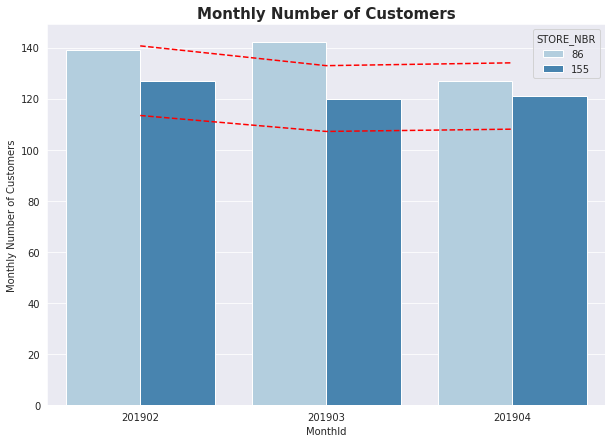

In [30]:
plot=TrialAssessment[(TrialAssessment['MonthId']>'201901') & (TrialAssessment['MonthId']<'201905')]
a=plot[['STORE_NBR_x','MonthId','Monthly Number of Customers_x']]
b=plot[['STORE_NBR_y','MonthId','Monthly Number of Customers_y']]
b=b.rename(columns={'STORE_NBR_y':'STORE_NBR_x','Monthly Number of Customers_y':'Monthly Number of Customers_x'})
a=a.append(b)
a=a.rename(columns={'STORE_NBR_x':'STORE_NBR','Monthly Number of Customers_x':'Monthly Number of Customers'})



fig,ax=plt.subplots(figsize=(10,7))
fig=sns.lineplot('MonthId','Control 95th% confidence interval',data=plot,color='red').set_title("Monthly Number of Customers",fontsize=15,fontweight="bold")
fig=sns.lineplot('MonthId','Control 5th% confidence interval',data=plot,color='red')
fig=sns.barplot('MonthId','Monthly Number of Customers',palette="Blues",hue='STORE_NBR' ,data=a)
fig.lines[0].set_linestyle("--")
fig.lines[1].set_linestyle("--")

plt.show()


### Correlations and Magnitudes with Store 88

In [31]:
Tstore=88
Store=Table[(Table['Measure']=='Monthly Overall Sales') | (Table['Measure']=='Monthly Number of Customers')]
Store=Store[Store['TrialStore']==Tstore]
Store['Combined Score']=0.5*Store['Correlation']+0.5*Store['Distance']
Store.sort_values(['Combined Score'],ascending=False)


,TrialStore,ControlStore,Measure,Correlation,TrialStore_d,ControlStore_d,Measure_d,Distance,Combined Score
2602,88,7,Monthly Number of Customers,0.938585,88,7,Monthly Number of Customers,0.976119,0.957352
3132,88,123,Monthly Number of Customers,0.925506,88,123,Monthly Number of Customers,0.982124,0.953815
3187,88,134,Monthly Number of Customers,0.945619,88,134,Monthly Number of Customers,0.921761,0.933690
3682,88,237,Monthly Number of Customers,0.676558,88,237,Monthly Number of Customers,0.994720,0.835639
3532,88,204,Monthly Number of Customers,0.773026,88,204,Monthly Number of Customers,0.887787,0.830407
...,...,...,...,...,...,...,...,...,...
3221,88,141,Monthly Overall Sales,-0.690590,88,141,Monthly Overall Sales,0.193152,-0.248719
2766,88,42,Monthly Overall Sales,-0.519338,88,42,Monthly Overall Sales,0.005706,-0.256816
2606,88,8,Monthly Overall Sales,-0.816296,88,8,Monthly Overall Sales,0.269281,-0.273508
3441,88,185,Monthly Overall Sales,-0.705768,88,185,Monthly Overall Sales,0.157952,-0.273908


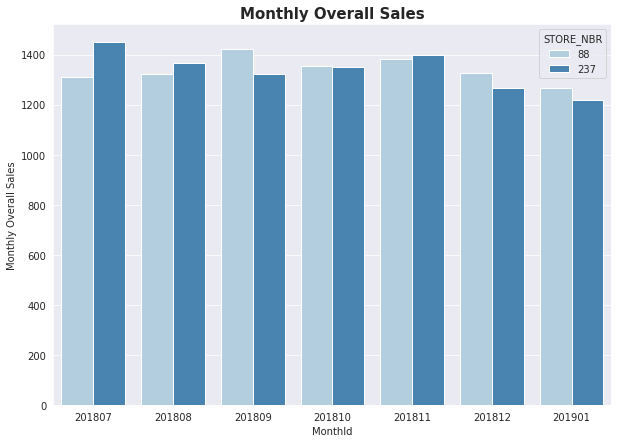

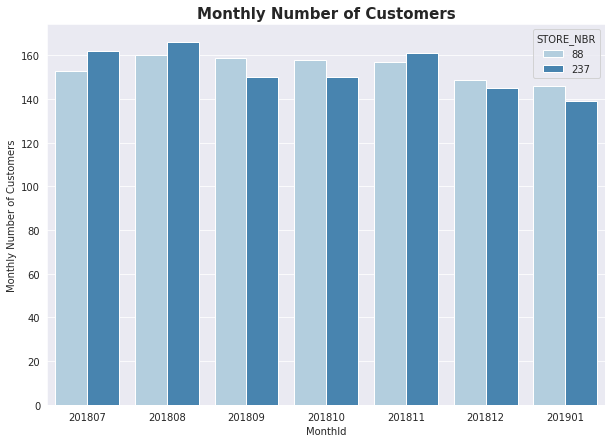

In [32]:
# Viz after picking a control for Pre-trial
Cnt_store=237
plot=Pre_trial[(Pre_trial['STORE_NBR']==Cnt_store) | (Pre_trial['STORE_NBR']==Tstore)]

#Monthly Overall Sales
fig,ax=plt.subplots(figsize=(10,7))
fig=sns.barplot('MonthId','Monthly Overall Sales',palette="Blues",hue='STORE_NBR' ,data=plot).set_title("Monthly Overall Sales",fontsize=15,fontweight="bold")
plt.show()
#fig,ax=plt.subplots(figsize=(10,7))
fig,ax=plt.subplots(figsize=(10,7))
fig=sns.barplot('MonthId','Monthly Number of Customers',palette="Blues",hue='STORE_NBR' ,data=plot).set_title("Monthly Number of Customers",fontsize=15,fontweight="bold")
plt.show()


Based on the information above, the ideal control store for the pre-trail period is 237.

#### Scaling pre-trial control sales to match pre-trial trial store sales

In [33]:
scale=(Pre_trial[Pre_trial['STORE_NBR']==Tstore]['Monthly Overall Sales'].sum())/(Pre_trial[Pre_trial['STORE_NBR']==Cnt_store]['Monthly Overall Sales'].sum())


Trial=Monthly_data[Monthly_data['STORE_NBR']==Tstore][['STORE_NBR','MonthId','Monthly Overall Sales']]
Scaled_control=Monthly_data[Monthly_data['STORE_NBR']==Cnt_store]
a=Scaled_control[Scaled_control['MonthId'] < '201902']['Monthly Overall Sales']*scale
Scaled_control.loc[a.index,'Monthly Overall Sales']=a

Scaled_control=Scaled_control[['STORE_NBR','MonthId','Monthly Overall Sales']]

Combined_Scaledcontrol_trial=pd.merge(Scaled_control,Trial,how='right',on='MonthId')


Combined_Scaledcontrol_trial['Change%']=(Combined_Scaledcontrol_trial['Monthly Overall Sales_x']-Combined_Scaledcontrol_trial['Monthly Overall Sales_y'])/Combined_Scaledcontrol_trial['Monthly Overall Sales_x']
Combined_Scaledcontrol_trial


/home/altec/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,STORE_NBR_x,MonthId,Monthly Overall Sales_x,STORE_NBR_y,Monthly Overall Sales_y,Change%
0,237,201807,1450.657086,88,1310.00,0.096961
1,237,201808,1369.931485,88,1323.80,0.033674
2,237,201809,1324.260425,88,1423.00,-0.074562
3,237,201810,1350.401097,88,1352.40,-0.001480
4,237,201811,1399.777923,88,1382.80,0.012129
5,237,201812,1266.971288,88,1325.20,-0.045959
6,237,201901,1221.600696,88,1266.40,-0.036673
7,237,201902,1404.800000,88,1370.20,0.024630
8,237,201903,1208.200000,88,1477.20,-0.222645
9,237,201904,1204.600000,88,1439.40,-0.194919


#### Null hypothesis: Trial period is the same as the Pre-trial

In [34]:
Combined_Scaledcontrol_trial=Combined_Scaledcontrol_trial[Combined_Scaledcontrol_trial['MonthId']<'201905']
df=Combined_Scaledcontrol_trial['MonthId'].nunique()-1
std=Combined_Scaledcontrol_trial[Combined_Scaledcontrol_trial['MonthId']<'201902']['Change%'].std()
mean=0#Combined_Scaledcontrol_trial['Change%'].mean()
tvalue=t.ppf(0.95,df)
Combined_Scaledcontrol_trial['t-value']=(Combined_Scaledcontrol_trial['Change%']-mean)/std
print("The T-value is:" ,tvalue)
Combined_Scaledcontrol_trial


The T-value is: 1.8331129326536335


/home/altec/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR_x,MonthId,Monthly Overall Sales_x,STORE_NBR_y,Monthly Overall Sales_y,Change%,t-value
0,237,201807,1450.657086,88,1310.0,0.096961,1.693651
1,237,201808,1369.931485,88,1323.8,0.033674,0.588201
2,237,201809,1324.260425,88,1423.0,-0.074562,-1.302402
3,237,201810,1350.401097,88,1352.4,-0.001480,-0.025856
4,237,201811,1399.777923,88,1382.8,0.012129,0.211862
5,237,201812,1266.971288,88,1325.2,-0.045959,-0.802782
6,237,201901,1221.600696,88,1266.4,-0.036673,-0.640574
7,237,201902,1404.800000,88,1370.2,0.024630,0.430218
8,237,201903,1208.200000,88,1477.2,-0.222645,-3.889024
9,237,201904,1204.600000,88,1439.4,-0.194919,-3.404728


As the T-value is 1.833 and this is a 2 sided test, March 2019 and April 2019 are statistically different as the |t-value|>1.833. We therefore reject the Null hypothesis and conclude that the Trial period is different from the Pre-trial period.

### Visual version

In [35]:
TrialAssessment=Combined_Scaledcontrol_trial[['STORE_NBR_x','MonthId','Monthly Overall Sales_x','STORE_NBR_y','Monthly Overall Sales_y']]
TrialAssessment['Control 95th% confidence interval']=TrialAssessment['Monthly Overall Sales_x']*(1 + std * 2)
TrialAssessment['Control 5th% confidence interval']=TrialAssessment['Monthly Overall Sales_x']*(1 - std * 2)

TrialAssessment


/home/altec/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR_x,MonthId,Monthly Overall Sales_x,STORE_NBR_y,Monthly Overall Sales_y,Control 95th% confidence interval,Control 5th% confidence interval
0,237,201807,1450.657086,88,1310.0,1616.756320,1284.557852
1,237,201808,1369.931485,88,1323.8,1526.787693,1213.075276
2,237,201809,1324.260425,88,1423.0,1475.887328,1172.633521
3,237,201810,1350.401097,88,1352.4,1505.021090,1195.781105
4,237,201811,1399.777923,88,1382.8,1560.051528,1239.504318
5,237,201812,1266.971288,88,1325.2,1412.038625,1121.903951
6,237,201901,1221.600696,88,1266.4,1361.473132,1081.728260
7,237,201902,1404.800000,88,1370.2,1565.648629,1243.951371
8,237,201903,1208.200000,88,1477.2,1346.538065,1069.861935
9,237,201904,1204.600000,88,1439.4,1342.525868,1066.674132


#### Plot

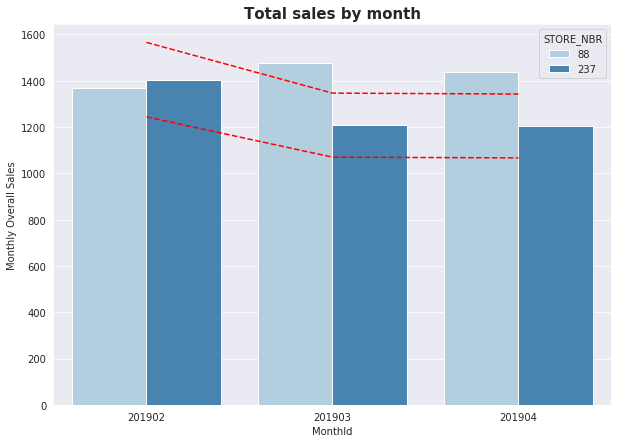

In [36]:
plot=TrialAssessment[(TrialAssessment['MonthId']>'201901') & (TrialAssessment['MonthId']<'201905')]
a=plot[['STORE_NBR_x','MonthId','Monthly Overall Sales_x']]
b=plot[['STORE_NBR_y','MonthId','Monthly Overall Sales_y']]
b=b.rename(columns={'STORE_NBR_y':'STORE_NBR_x','Monthly Overall Sales_y':'Monthly Overall Sales_x'})
a=a.append(b)
a=a.rename(columns={'STORE_NBR_x':'STORE_NBR','Monthly Overall Sales_x':'Monthly Overall Sales'})



fig,ax=plt.subplots(figsize=(10,7))
fig=sns.lineplot('MonthId','Control 95th% confidence interval',data=plot,color='red').set_title("Total sales by month",fontsize=15,fontweight="bold")
fig=sns.lineplot('MonthId','Control 5th% confidence interval',data=plot,color='red')
fig=sns.barplot('MonthId','Monthly Overall Sales',palette="Blues",hue='STORE_NBR' ,data=a)
fig.lines[0].set_linestyle("--")
fig.lines[1].set_linestyle("--")
plt.show()


### Number of customers Store 88

#### Apply scaling

In [37]:
scale=(Pre_trial[Pre_trial['STORE_NBR']==Tstore]['Monthly Number of Customers'].sum())/(Pre_trial[Pre_trial['STORE_NBR']==Cnt_store]['Monthly Number of Customers'].sum())


Trial=Monthly_data[Monthly_data['STORE_NBR']==Tstore][['STORE_NBR','MonthId','Monthly Number of Customers']]
Scaled_control=Monthly_data[Monthly_data['STORE_NBR']==Cnt_store]
a=Scaled_control[Scaled_control['MonthId'] < '201902']['Monthly Number of Customers']*scale
Scaled_control.loc[a.index,'Monthly Number of Customers']=a

Scaled_control=Scaled_control[['STORE_NBR','MonthId','Monthly Number of Customers']]

Combined_Scaledcontrol_trial=pd.merge(Scaled_control,Trial,how='right',on='MonthId')


Combined_Scaledcontrol_trial['Change%']=(Combined_Scaledcontrol_trial['Monthly Number of Customers_x']-Combined_Scaledcontrol_trial['Monthly Number of Customers_y'])/Combined_Scaledcontrol_trial['Monthly Number of Customers_x']
Combined_Scaledcontrol_trial


/home/altec/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,STORE_NBR_x,MonthId,Monthly Number of Customers_x,STORE_NBR_y,Monthly Number of Customers_y,Change%
0,237,201807,163.358807,88,153,0.063411
1,237,201808,167.392358,88,160,0.044162
2,237,201809,151.258155,88,159,-0.051183
3,237,201810,151.258155,88,158,-0.044572
4,237,201811,162.350419,88,157,0.032956
5,237,201812,146.216216,88,149,-0.019039
6,237,201901,140.165890,88,146,-0.041623
7,237,201902,157.000000,88,154,0.019108
8,237,201903,137.000000,88,170,-0.240876
9,237,201904,136.000000,88,162,-0.191176


#### Null hypothesis: Trial period is the same as the Pre-trial

In [38]:
Combined_Scaledcontrol_trial=Combined_Scaledcontrol_trial[Combined_Scaledcontrol_trial['MonthId']<'201905']
df=Combined_Scaledcontrol_trial['MonthId'].nunique()-1
std=Combined_Scaledcontrol_trial[Combined_Scaledcontrol_trial['MonthId']<'201902']['Change%'].std()
mean=0#Combined_Scaledcontrol_trial['Change%'].mean()
tvalue=t.ppf(0.95,df)
Combined_Scaledcontrol_trial['t-value']=(Combined_Scaledcontrol_trial['Change%']-mean)/std
print("The T-value is:" ,tvalue)
Combined_Scaledcontrol_trial


The T-value is: 1.8331129326536335


/home/altec/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STORE_NBR_x,MonthId,Monthly Number of Customers_x,STORE_NBR_y,Monthly Number of Customers_y,Change%,t-value
0,237,201807,163.358807,88,153,0.063411,1.325942
1,237,201808,167.392358,88,160,0.044162,0.923432
2,237,201809,151.258155,88,159,-0.051183,-1.070245
3,237,201810,151.258155,88,158,-0.044572,-0.932003
4,237,201811,162.350419,88,157,0.032956,0.689115
5,237,201812,146.216216,88,149,-0.019039,-0.398105
6,237,201901,140.165890,88,146,-0.041623,-0.870342
7,237,201902,157.000000,88,154,0.019108,0.399557
8,237,201903,137.000000,88,170,-0.240876,-5.036755
9,237,201904,136.000000,88,162,-0.191176,-3.997532


As the T-value is 1.833 and this is a 2 sided test, March 2019 and April 2019 are statistically different as the |t-value|>1.833. We therefore reject the Null hypothesis and conclude that the Trial period is different from the Pre-trial period.

### Visual version

In [39]:
TrialAssessment=Combined_Scaledcontrol_trial[['STORE_NBR_x','MonthId','Monthly Number of Customers_x','STORE_NBR_y','Monthly Number of Customers_y']]


In [40]:
TrialAssessment['Control 95th% confidence interval']=TrialAssessment['Monthly Number of Customers_x']*(1 + std * 2)
TrialAssessment['Control 5th% confidence interval']=TrialAssessment['Monthly Number of Customers_x']*(1 - std * 2)

TrialAssessment


/home/altec/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STORE_NBR_x,MonthId,Monthly Number of Customers_x,STORE_NBR_y,Monthly Number of Customers_y,Control 95th% confidence interval,Control 5th% confidence interval
0,237,201807,163.358807,88,153,178.983629,147.733985
1,237,201808,167.392358,88,160,183.402978,151.381738
2,237,201809,151.258155,88,159,165.725582,136.790727
3,237,201810,151.258155,88,158,165.725582,136.790727
4,237,201811,162.350419,88,157,177.878792,146.822047
5,237,201812,146.216216,88,149,160.201396,132.231036
6,237,201901,140.165890,88,146,153.572373,126.759407
7,237,201902,157.000000,88,154,172.016619,141.983381
8,237,201903,137.000000,88,170,150.103674,123.896326
9,237,201904,136.000000,88,162,149.008027,122.991973


#### Plot

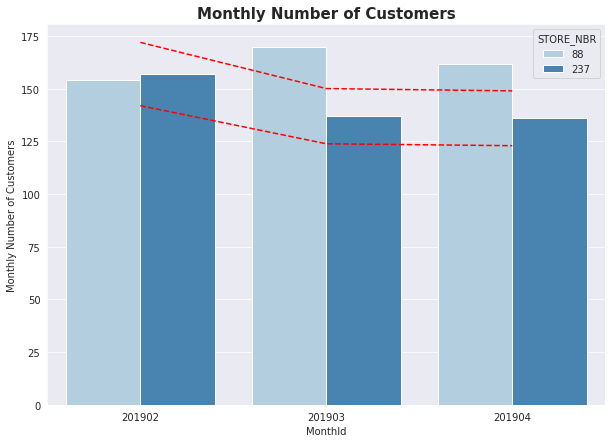

In [41]:
plot=TrialAssessment[(TrialAssessment['MonthId']>'201901') & (TrialAssessment['MonthId']<'201905')]
a=plot[['STORE_NBR_x','MonthId','Monthly Number of Customers_x']]
b=plot[['STORE_NBR_y','MonthId','Monthly Number of Customers_y']]
b=b.rename(columns={'STORE_NBR_y':'STORE_NBR_x','Monthly Number of Customers_y':'Monthly Number of Customers_x'})
a=a.append(b)
a=a.rename(columns={'STORE_NBR_x':'STORE_NBR','Monthly Number of Customers_x':'Monthly Number of Customers'})



fig,ax=plt.subplots(figsize=(10,7))
fig=sns.lineplot('MonthId','Control 95th% confidence interval',data=plot,color='red').set_title("Monthly Number of Customers",fontsize=15,fontweight="bold")
fig=sns.lineplot('MonthId','Control 5th% confidence interval',data=plot,color='red')
fig=sns.barplot('MonthId','Monthly Number of Customers',palette="Blues",hue='STORE_NBR' ,data=a)
fig.lines[0].set_linestyle("--")
fig.lines[1].set_linestyle("--")
plt.show()


### Conclusion

The control stores 233, 155, 237 have been selected for the trial stores 77, 86 and 88 respectively.

The results for trial stores 77 and 88 during the trial period shows a significant difference in at least two of the three trial months but this is not the case for trial store 86.